In [14]:
%matplotlib inline

In [15]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf', 'svg')
matplotlib.rcParams['svg.fonttype'] = 'none'

In [16]:
RAW_DATA_ROOT = Path(r"C:\Users\Monthy\Documents\projects\thesis\thesis-data-suite\data\raw\lc-summed")
ANALYSIS_ROOT = Path(r"C:\Users\Monthy\Documents\projects\thesis\thesis-data-suite\data\analysis\lc-summed\cs")

In [17]:
scenes = [("pipers-alley",  "1044#3x_3y_2z"),
          ("ziggurat-city", "1170#3x_3y_2z"),
          ("spaceship-indoor", "1260#3x_3y_2z"),
         ]

tile_sizes = [8, 16, 32]
resolutions = [320, 640, 960, 1280, 1920, 2560]
pipelines = ["DEFERRED"]

res_path = RAW_DATA_ROOT / Path("resolution")

In [18]:
def json_to_dataframe(json_dic : dict) -> pd.DataFrame:
    '''
    Convert a json data file spit out by nTiled into something just slightly more useful
    '''
    # get all functions tracked from first frame
    frames = json_dic["frames"]
    
    frames_i = {}
    frames_n_calc = {}
    for f in frames:
        f_i = int(f["frame"])
        
        frames_i[f_i] = f_i
        frames_n_calc[f_i] = int(f["n_calc"])
        
    data_series = { "index": pd.Series(frames_i, name="index"),
                    "n_calc": pd.Series(frames_n_calc, name="n_calc")
                  }
    
    dataframe = pd.DataFrame(data_series)
    return dataframe

In [21]:
def plot_resolution(scene: str, pipeline_type: str, do_export=False):
    # Acquire data
    # ------------------------------------------------------------------------------------------------------
    attenuated_data_folder = res_path / Path("ns/{}/{}".format(pipeline_type, scene))
    
    df_attenuated = pd.DataFrame([], columns=["n_calc_per_frame", "resolution"])
    index = 0
    
    for res in resolutions:
        attenuated_file_path = attenuated_data_folder / Path("{}/lc_data.json".format(res))
        with open(str(attenuated_file_path), 'r') as f:
            data_json = json.loads(f.read())
        df_att = json_to_dataframe(data_json)
        df_val = df_att["n_calc"].mean() / (1 * 10 ** 5)
        df_attenuated.loc[index] = [df_val, res]
        index += 1
    
    
    
    # ------------------------------------------------------------------------------------------------------
    tiled_data_folder = res_path / Path("ts/{}/{}/32".format(pipeline_type, scene))
    
    df_tiled = pd.DataFrame([], columns=["n_calc_per_frame", "resolution"])
    index = 0
    
    for res in resolutions:
        tiled_file_path = tiled_data_folder / Path("{}/lc_data.json".format(res))
        with open(str(tiled_file_path), 'r') as f:
            data_json = json.loads(f.read())
        df_til = json_to_dataframe(data_json)
        df_val = df_til["n_calc"].mean() / (1 * 10 ** 6) #/ (res * res)               
        df_tiled.loc[index] = [df_val, res]          
        index += 1
        
        
    # ------------------------------------------------------------------------------------------------------
    clustered_data_folder = res_path / Path("cs/{}/{}".format(pipeline_type, scene))
    
    dfs_clustered = {x : pd.DataFrame([], columns=["n_calc_per_frame", "resolution"]) for x in tile_sizes }
    
    for x in tile_sizes:
        index = 0
        for res in resolutions:
            clustered_file_path = clustered_data_folder / Path("{}/{}/lc_data.json".format(x, res))
            with open(str(clustered_file_path), 'r') as f:
                data_json = json.loads(f.read())
            df_clustered = json_to_dataframe(data_json)
                
            df_val = df_clustered["n_calc"].mean() / (1 * 10 ** 6) #/ (res * res)               
                
            dfs_clustered[x].loc[index] = [df_val, res]            
            index += 1


    # Plot resolution
    # ------------------------------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("resolution", "n_calc_per_frame",
                data=df_attenuated,
                ax=ax,
                #fit_reg=False,
                label= "naief",
                order=2)
    
    sns.regplot("resolution", "n_calc_per_frame", 
                data=df_tiled, 
                ax=ax,
                #fit_reg=False,
                label="Tiled - 32",
                order=2)
    
    for x in tile_sizes:
        sns.regplot("resolution", "n_calc_per_frame", 
                    data=dfs_clustered[x], 
                    #fit_reg=False,
                    ax=ax,
                    label="Clustered - {}".format(x),
                    order=2)
    
    ax.set(xlabel='Resolutie (px)', ylabel='Aantal lichtberekeningen (10^6)')
    ax.set(ylim=(-49, None))
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 25

    
    #  Export graph
    # ------------------------------------------------------------------------------------------------------
    if do_export:
        path = ANALYSIS_ROOT / Path("graphs/resolution/{}".format(pipeline_type))   
        
        if not path.exists() or path.is_file():
            path.mkdir(parents=True)      
        
        output_path = path / Path("resolution_{}.svg".format(scene))
        fig.savefig(str(output_path), bbox_inches='tight')
        plt.close(fig)
        
    #  Show graph
    # ------------------------------------------------------------------------------------------------------
    else:      
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

In [22]:
scenelets = ["pipers-alley",
             "ziggurat-city",
             "spaceship-indoor",
            ]

pts = ["deferred",]
for pt in pts:
    for scene in scenelets:
        #plot_resolution(scene, pt)
        plot_resolution(scene, pt, do_export=True)

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\seaborn\linearmodels.py:236: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
c:\program files\python3\lib\site-packages\se

In [23]:
light_path = RAW_DATA_ROOT / Path("lights")

scenes = {"pipers-alley" : [  "58#1x_1y_1z",
                             "116#2x_1y_1z",
                             "174#1x_3y_1z",
                             "232#1x_2y_2z",
                             "348#1x_2y_3z",
                             "464#2x_2y_2z",
                             "522#1x_3y_3z",
                             "696#3x_2y_2z",
                            "1044#3x_3y_2z",
                           ],
          "ziggurat-city" : [  "65#1x_1y_1z",
                              "130#2x_1y_1z",
                              "195#1x_1y_3z",
                              "260#2x_2y_1z",
                              "390#3x_1y_2z",
                              "520#2x_2y_2z",
                              "585#3x_3y_1z",
                              "780#3x_2y_2z",
                             "1170#3x_3y_2z",
                            ],
          "spaceship-indoor" : [  "70#1x_1y_1z",
                                 "140#2x_1y_1z",
                                 "210#3x_1y_1z",
                                 "280#2x_2y_1z",
                                 "420#3x_2y_1z",
                                 "560#2x_2y_2z",
                                 "630#3x_3y_1z",
                                 "840#3x_2y_2z",
                                "1260#3x_3y_2z",
                               ]
         }

In [28]:
def plot_lights(scene: str, pipeline_type: str, do_export=False):
    # Acquire data
    # ------------------------------------------------------------------------------------------------------
    attenuated_data_folder = light_path / Path("ns/{}/{}".format(pipeline_type, scene))
    
    df_attenuated = pd.DataFrame([], columns=["n_calc_per_frame", "n_lights"])
    index = 0
    
    for light in scenes[scene]:
        attenuated_file_path = attenuated_data_folder / Path("{}/lc_data.json".format(light))
        with open(str(attenuated_file_path), 'r') as f:
            data_json = json.loads(f.read())
        df_att = json_to_dataframe(data_json)
        df_val = df_att["n_calc"].mean() / (1 * 10 ** 5)
        df_attenuated.loc[index] = [df_val, int(light.split("#")[0])]
        index += 1

    
    # ------------------------------------------------------------------------------------------------------
    tiled_data_folder = light_path / Path("ts/{}/{}/32".format(pipeline_type, scene))
    
    df_tiled = pd.DataFrame([], columns=["n_calc_per_frame", "n_lights"])
    index = 0
    
    for light in scenes[scene]:
        tiled_file_path = tiled_data_folder / Path("{}/lc_data.json".format(light))
        with open(str(tiled_file_path), 'r') as f:
            data_json = json.loads(f.read())
        df_til = json_to_dataframe(data_json)
        df_val = df_til["n_calc"].mean() / (1 * 10 ** 6) #/ (res * res)               
        df_tiled.loc[index] = [df_val, int(light.split("#")[0])]          
        index += 1
        
        
    # ------------------------------------------------------------------------------------------------------
    clustered_data_folder = light_path / Path("cs/{}/{}".format(pipeline_type, scene))
    
    dfs_clustered = {x : pd.DataFrame([], columns=["n_calc_per_frame", "n_lights"]) for x in tile_sizes }
    
    for x in tile_sizes:
        index = 0
        for light in scenes[scene]:
            clustered_file_path = clustered_data_folder / Path("{}/{}/lc_data.json".format(x, light))
            with open(str(clustered_file_path), 'r') as f:
                data_json = json.loads(f.read())
            df_clustered = json_to_dataframe(data_json)
                
            df_val = df_clustered["n_calc"].mean() / (1 * 10 ** 6) #/ (res * res)               
                
            dfs_clustered[x].loc[index] = [df_val, int(light.split("#")[0])]            
            index += 1

    
    # Plot lights
    # ------------------------------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("n_lights", "n_calc_per_frame",
                data=df_attenuated,
                ax=ax,
                #fit_reg=False,
                label= "naief",
                order=1)
    
    sns.regplot("n_lights", "n_calc_per_frame", 
                data=df_tiled, 
                ax=ax,
                #fit_reg=False,
                label="Tiled - 32",
                order=1)
    
    for x in tile_sizes:
        sns.regplot("n_lights", "n_calc_per_frame", 
                    data=dfs_clustered[x], 
                    #fit_reg=False,
                    ax=ax,
                    label="Clustered - {}".format(x),
                    order=1)
    
    ax.set(xlabel='Aantal lichten', ylabel='Aantal lichtberekeningen (10^6)')
    ax.set(ylim=(-49, None))
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 25

    #  Export graph
    # ------------------------------------------------------------------------------------------------------
    if do_export:
        path = ANALYSIS_ROOT / Path("graphs/lights/{}".format(pipeline_type))   
        
        if not path.exists() or path.is_file():
            path.mkdir(parents=True)      
        
        output_path = path / Path("lights_{}.svg".format(scene))
        fig.savefig(str(output_path), bbox_inches='tight')
        plt.close(fig)        
        
    #  Show graph
    # ------------------------------------------------------------------------------------------------------
    else:      
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

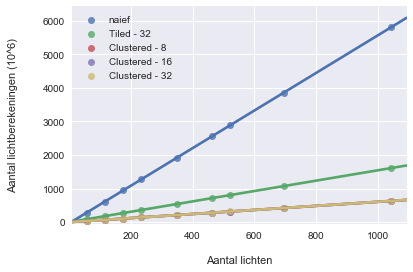

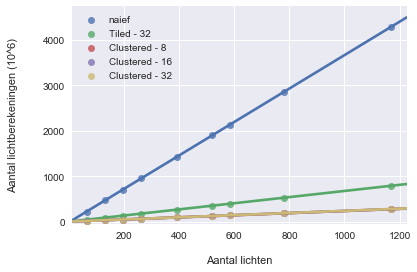

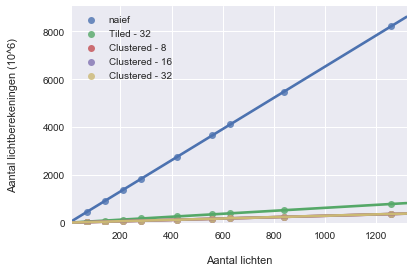

In [39]:
scenelets = ["pipers-alley",
             "ziggurat-city",
             "spaceship-indoor",
            ]

pts = ["deferred",]
for pt in pts:
    for scene in scenelets:
        plot_lights(scene, pt)
        plot_lights(scene, pt, do_export=True)

In [32]:
def plot_frames_low(scene, do_export=False):
    path = Path(r'C:\Users\Monthy\Documents\projects\thesis\thesis-data-suite\data\raw\lc-summed\frames')
    
    # Acquire data
    # ------------------------------------------------------------------------------------------------------
    attenuated_path = path / Path("ns/deferred/{}/lc_data.json".format(scene))
    
    with open(str(attenuated_path), 'r') as f:
        data_json = json.loads(f.read())
    attenuated_df = json_to_dataframe(data_json)
    attenuated_df["n_calc"] /= 10 ** 5
    
    
    # ------------------------------------------------------------------------------------------------------
    tiled_path = path / Path("ts/deferred/{}/32/lc_data.json".format(scene))
    
    with open(str(tiled_path), 'r') as f:
        data_json = json.loads(f.read())
    tiled_df = json_to_dataframe(data_json)
    tiled_df["n_calc"] /=  10 ** 6
    
    
    # ------------------------------------------------------------------------------------------------------
    clustered_path = path / Path("cs/deferred/{}".format(scene))
    clustered_dfs = {}
    
    for x in tile_sizes:
        clustered_path_file = clustered_path / Path("{}/lc_data.json".format(x))
        with open(str(clustered_path_file), 'r') as f:
            data_json = json.loads(f.read())
        clustered_dfs[x] = json_to_dataframe(data_json)
        clustered_dfs[x]["n_calc"] /=  10 ** 6

            
        
    # Plot frames
    # ------------------------------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
            
    sns.regplot("index", "n_calc", 
                data=attenuated_df, fit_reg=False, 
                ax=ax,
                label="Attenuated",
                scatter_kws={"s": 15})
    
    sns.regplot("index", "n_calc", 
                data=tiled_df, fit_reg=False, 
                ax=ax,
                label="Tiled - 32",
                scatter_kws={"s": 15})
    
    for x in tile_sizes:
        sns.regplot("index", "n_calc", 
                    data=clustered_dfs[x], fit_reg=False, 
                    ax=ax,
                    label="Clustered - {}".format(x),
                    scatter_kws={"s": 15})
    
    ax.set(xlabel='Frame', ylabel='Aantal lichtberekeningen (10^6)')
    
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 25

    #  Export graph
    # ------------------------------------------------------------------------------------------------------
    if do_export:
        path = ANALYSIS_ROOT / Path("graphs/frames/deferred/")
        
        if not path.exists() or path.is_file():
            path.mkdir(parents=True)            
            
        output_path = path / Path("frames_320_{}.svg".format(scene))
        fig.savefig(str(output_path), bbox_inches='tight')
        plt.close(fig)        
        
    #  Show graph
    # ------------------------------------------------------------------------------------------------------
    else:      
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

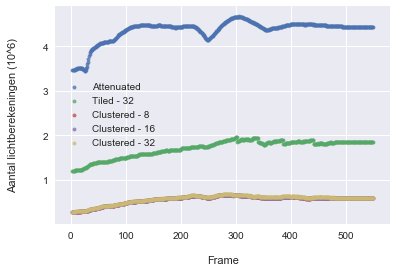

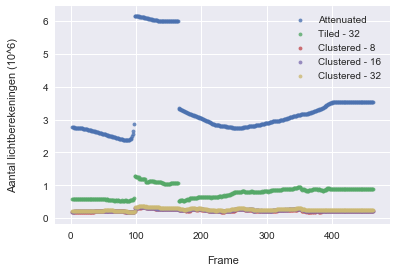

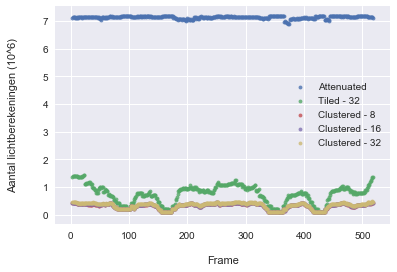

In [36]:
scenelets = ["pipers-alley",
             "ziggurat-city",
             "spaceship-indoor",
            ]

for scene in scenelets:
    plot_frames_low(scene)
    plot_frames_low(scene, do_export=True)

In [34]:
def plot_frames_high(scene, do_export=False):
    path = Path(r'C:\Users\Monthy\Documents\projects\thesis\thesis-data-suite\data\raw\lc-summed\resolution')
    
    # Acquire data
    # ------------------------------------------------------------------------------------------------------
    attenuated_path = path / Path("ns/deferred/{}/2560/lc_data.json".format(scene))
    
    with open(str(attenuated_path), 'r') as f:
        data_json = json.loads(f.read())
    attenuated_df = json_to_dataframe(data_json)
    attenuated_df["n_calc"] /= 10 ** 5
    
    
    # ------------------------------------------------------------------------------------------------------
    tiled_path = path / Path("ts/deferred/{}/32/2560/lc_data.json".format(scene))
    
    with open(str(tiled_path), 'r') as f:
        data_json = json.loads(f.read())
    tiled_df = json_to_dataframe(data_json)
    tiled_df["n_calc"] /=  10 ** 6
    
    
    # ------------------------------------------------------------------------------------------------------
    clustered_path = path / Path("cs/deferred/{}".format(scene))
    clustered_dfs = {}
    
    for x in tile_sizes:
        clustered_path_file = clustered_path / Path("{}/2560/lc_data.json".format(x))
        with open(str(clustered_path_file), 'r') as f:
            data_json = json.loads(f.read())
        clustered_dfs[x] = json_to_dataframe(data_json)
        clustered_dfs[x]["n_calc"] /=  10 ** 6

            
        
    # Plot frames
    # ------------------------------------------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
            
    sns.regplot("index", "n_calc", 
                data=attenuated_df, fit_reg=False, 
                ax=ax,
                label="Attenuated",
                scatter_kws={"s": 15})
    
    sns.regplot("index", "n_calc", 
                data=tiled_df, fit_reg=False, 
                ax=ax,
                label="Tiled - 32",
                scatter_kws={"s": 15})
    
    for x in tile_sizes:
        sns.regplot("index", "n_calc", 
                    data=clustered_dfs[x], fit_reg=False, 
                    ax=ax,
                    label="Clustered - {}".format(x),
                    scatter_kws={"s": 15})
    
    ax.set(xlabel='Frame', ylabel='Aantal lichtberekeningen (10^6)')
    
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 25

    #  Export graph
    # ------------------------------------------------------------------------------------------------------
    if do_export:
        path = ANALYSIS_ROOT / Path("graphs/frames/deferred/")
        
        if not path.exists() or path.is_file():
            path.mkdir(parents=True)            
            
        output_path = path / Path("frames_2560_{}.svg".format(scene))
        fig.savefig(str(output_path), bbox_inches='tight')
        plt.close(fig)        
        
    #  Show graph
    # ------------------------------------------------------------------------------------------------------
    else:      
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.show()

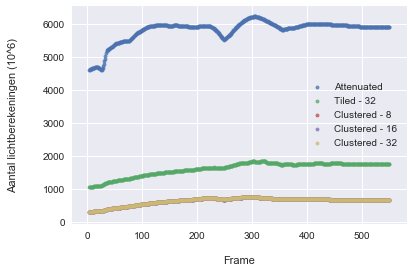

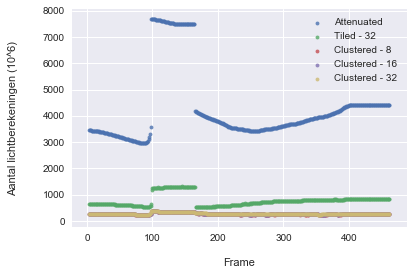

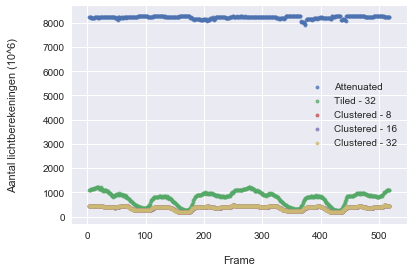

In [38]:
scenelets = ["pipers-alley",
             "ziggurat-city",
             "spaceship-indoor",
            ]

for scene in scenelets:
    plot_frames_high(scene)
    plot_frames_high(scene, do_export=True)